In [1]:
#%pip install optuna

In [2]:
#%pip install optuna-integration[lightgbm]

In [3]:
import numpy as np
import pandas as pd
from lightgbm import LGBMRegressor
import optuna.integration.lightgbm as lgb
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import warnings
import plotly.graph_objects as go
from plotly.subplots import make_subplots
warnings.filterwarnings("ignore")

In [4]:
df = pd.read_csv('./adult.csv')

In [5]:
df.shape

(48842, 15)

In [6]:
df.describe()

,age,fnlwgt,educational-num,capital-gain,capital-loss,hours-per-week
count,48842.000000,4.884200e+04,48842.000000,48842.000000,48842.000000,48842.000000
mean,38.643585,1.896641e+05,10.078089,1079.067626,87.502314,40.422382
std,13.710510,1.056040e+05,2.570973,7452.019058,403.004552,12.391444
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.175505e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.781445e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.376420e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.490400e+06,16.000000,99999.000000,4356.000000,99.000000


In [7]:
df.head(10)

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K
5,34,Private,198693,10th,6,Never-married,Other-service,Not-in-family,White,Male,0,0,30,United-States,<=50K
6,29,?,227026,HS-grad,9,Never-married,?,Unmarried,Black,Male,0,0,40,United-States,<=50K
7,63,Self-emp-not-inc,104626,Prof-school,15,Married-civ-spouse,Prof-specialty,Husband,White,Male,3103,0,32,United-States,>50K
8,24,Private,369667,Some-college,10,Never-married,Other-service,Unmarried,White,Female,0,0,40,United-States,<=50K
9,55,Private,104996,7th-8th,4,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,10,United-States,<=50K


There are totally 15 columns in this dataset. 6 of them are numerical data which are age, fnlwgt, educational-num, capital-gain, capital-loss and hours-per-week. other columns are categorical data. Let's check for missing data first.

In [8]:
df.isna().sum()

age                0
workclass          0
fnlwgt             0
education          0
educational-num    0
marital-status     0
occupation         0
relationship       0
race               0
gender             0
capital-gain       0
capital-loss       0
hours-per-week     0
native-country     0
income             0
dtype: int64

So there is no numerical missing data

In [9]:
categorical_column=['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'gender', 'native-country', 'income']
df[df[categorical_column]=='?'].count()

age                   0
workclass          2799
fnlwgt                0
education             0
educational-num       0
marital-status        0
occupation         2809
relationship          0
race                  0
gender                0
capital-gain          0
capital-loss          0
hours-per-week        0
native-country      857
income                0
dtype: int64

We can not deal with missing data. Also even we delete all missing data, we still have enough data for our analysis. So we will delete all data with missing workclass or occupation or native-country.

In [10]:
newdf = df.drop(df[df['occupation']=='?'].index)

In [11]:
newdf = newdf.drop(newdf[newdf['native-country']=='?'].index)

In [12]:
newdf.shape

(45222, 15)

In [13]:
newdf[newdf[categorical_column]=='?'].count()

age                0
workclass          0
fnlwgt             0
education          0
educational-num    0
marital-status     0
occupation         0
relationship       0
race               0
gender             0
capital-gain       0
capital-loss       0
hours-per-week     0
native-country     0
income             0
dtype: int64

Now there is no missing data. Next, we will find a way to deal with categorical data.

In [14]:
newdf[categorical_column].nunique()

workclass          7
education         16
marital-status     7
occupation        14
relationship       6
gender             2
native-country    41
income             2
dtype: int64

In [15]:
newdf['workclass'].unique()

array(['Private', 'Local-gov', 'Self-emp-not-inc', 'Federal-gov',
       'State-gov', 'Self-emp-inc', 'Without-pay'], dtype=object)

In [16]:
newdf['education'].unique()

array(['11th', 'HS-grad', 'Assoc-acdm', 'Some-college', '10th',
       'Prof-school', '7th-8th', 'Bachelors', 'Masters', '5th-6th',
       'Assoc-voc', '9th', 'Doctorate', '12th', '1st-4th', 'Preschool'],
      dtype=object)

In [17]:
newdf['marital-status'].unique()

array(['Never-married', 'Married-civ-spouse', 'Widowed', 'Separated',
       'Divorced', 'Married-spouse-absent', 'Married-AF-spouse'],
      dtype=object)

In [18]:
newdf['occupation'].unique()

array(['Machine-op-inspct', 'Farming-fishing', 'Protective-serv',
       'Other-service', 'Prof-specialty', 'Craft-repair', 'Adm-clerical',
       'Exec-managerial', 'Tech-support', 'Sales', 'Priv-house-serv',
       'Transport-moving', 'Handlers-cleaners', 'Armed-Forces'],
      dtype=object)

In [19]:
newdf['relationship'].unique()

array(['Own-child', 'Husband', 'Not-in-family', 'Unmarried', 'Wife',
       'Other-relative'], dtype=object)

In [20]:
newdf['gender'].unique()

array(['Male', 'Female'], dtype=object)

In [21]:
newdf['native-country'].unique()

array(['United-States', 'Peru', 'Guatemala', 'Mexico',
       'Dominican-Republic', 'Ireland', 'Germany', 'Philippines',
       'Thailand', 'Haiti', 'El-Salvador', 'Puerto-Rico', 'Vietnam',
       'South', 'Columbia', 'Japan', 'India', 'Cambodia', 'Poland',
       'Laos', 'England', 'Cuba', 'Taiwan', 'Italy', 'Canada', 'Portugal',
       'China', 'Nicaragua', 'Honduras', 'Iran', 'Scotland', 'Jamaica',
       'Ecuador', 'Yugoslavia', 'Hungary', 'Hong', 'Greece',
       'Trinadad&Tobago', 'Outlying-US(Guam-USVI-etc)', 'France',
       'Holand-Netherlands'], dtype=object)

In [22]:
newdf['income'].unique()

array(['<=50K', '>50K'], dtype=object)

In this project, we are trying to find out the relationship between other features with income. So we also have to transfer income column to numerical data type.

In [23]:
newdf.loc[newdf['income']=='<=50K', 'income'] = 0
newdf.loc[newdf['income']=='>50K', 'income'] = 1

<Axes: >

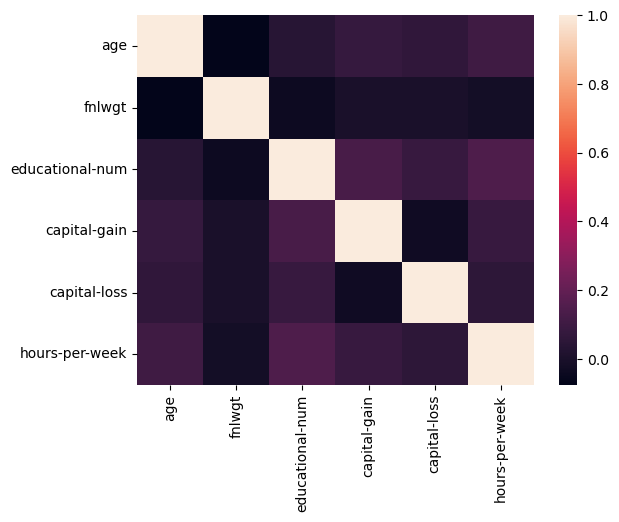

In [24]:
numerical_column = ['age', 'fnlwgt', 'educational-num', 'capital-gain', 'capital-loss', 'hours-per-week']
corr = newdf[numerical_column].corr()
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

For all numerical data, they are almost have no relationship with each others. So we have to keep them all

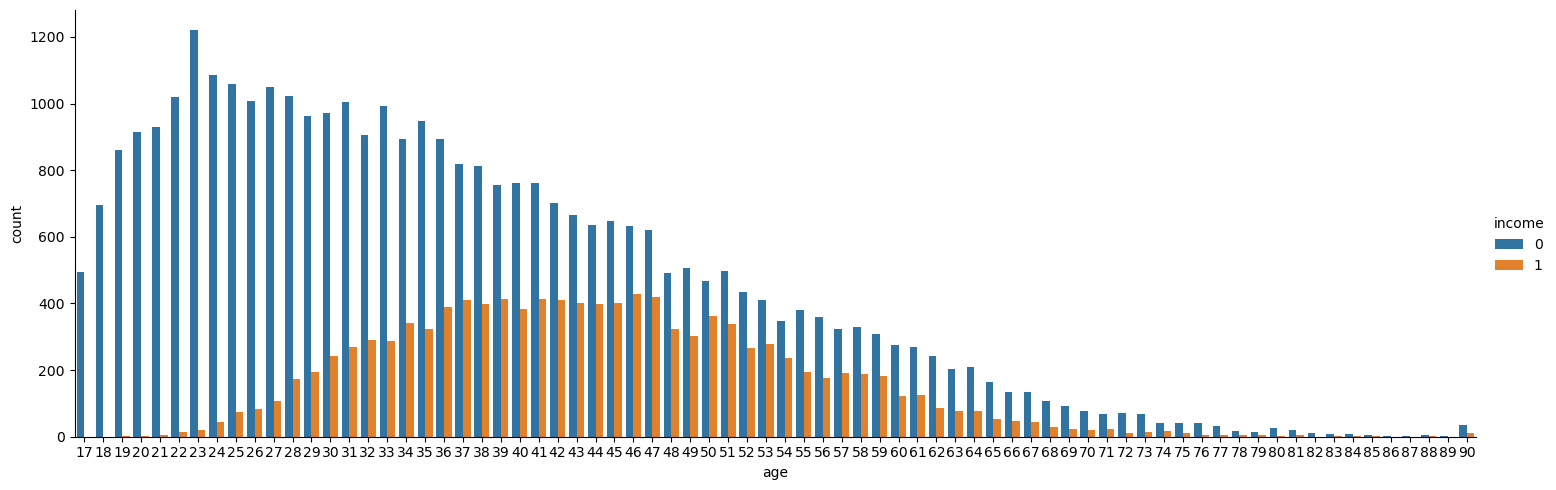

In [25]:
age_data = newdf[['age', 'income']]
age = sns.catplot(x='age', hue='income', data=age_data, kind='count', aspect=3)

So we can see, the number of people who's income is '<=50K' are always bigger than the number of people who's income is '>50K'. And for income is '<=50K', it has peak at age of 23. Then it drops fast. But for income is '>50K', it has peak range of age 37 to age 47. 

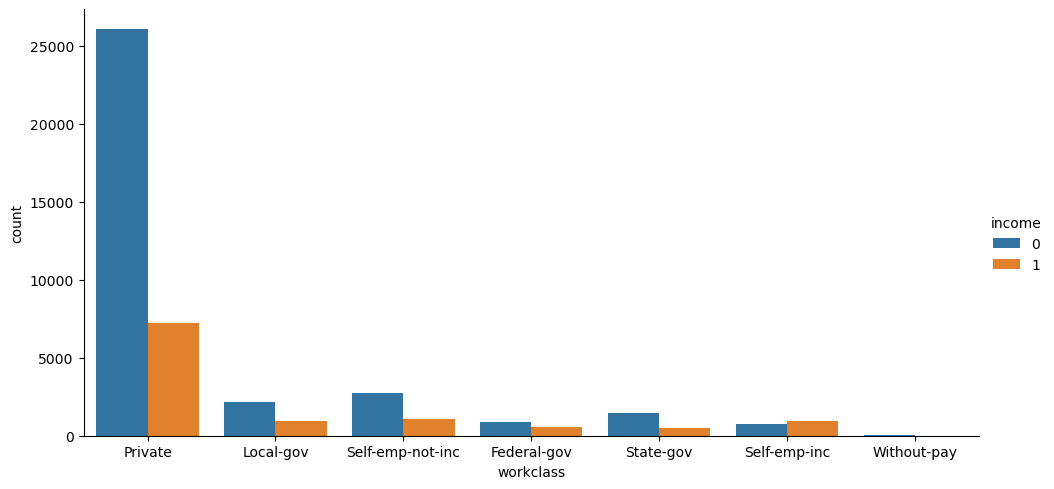

In [26]:
workclass_data = newdf[['workclass', 'income']]
workclass = sns.catplot(x='workclass', hue='income', data=workclass_data, kind='count', aspect=2)

fnlwgt: final weight. In other words, this is the number of people the census believes the entry represents.

So It represent how many peoploe could one line repesent.

In [27]:
fnlwgt_data = newdf[['fnlwgt', 'income']]
newfnlwgt_data = pd.DataFrame()
newfnlwgt_data['people'] = fnlwgt_data.groupby('income').sum()
newfnlwgt_data

,people
income,
0,6468619737
1,2111564418


This is another way shows that peole with income of '<=50K' is 3 times of peole with income of '>50K'

Education and educational_num are the same. They are both talking about how many year does that people getting education. So we just have to search in educational_num.

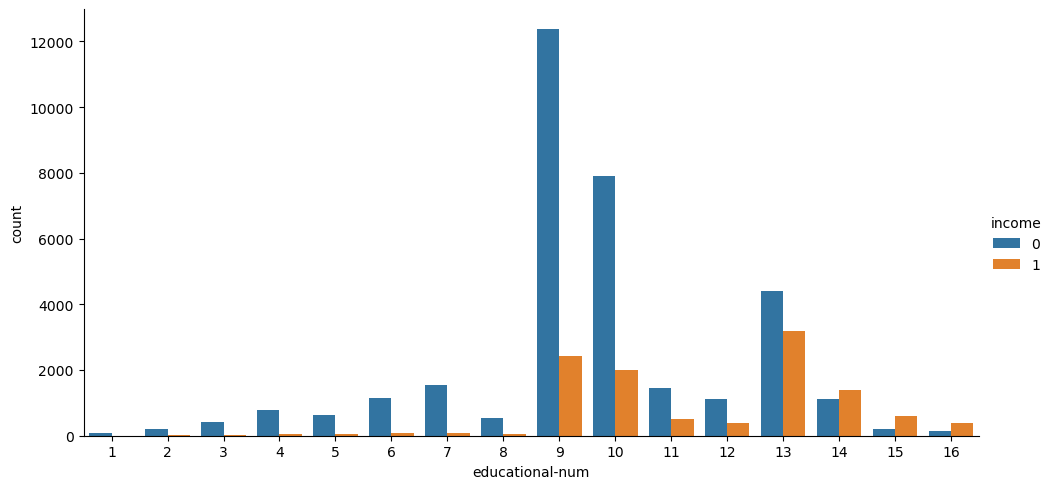

In [28]:
education_data = newdf[['educational-num', 'income']]
education = sns.catplot(x='educational-num', hue='income', data=education_data, kind='count', aspect=2)

In this graph, it could show us that the more education you get, the more money you could earn. 

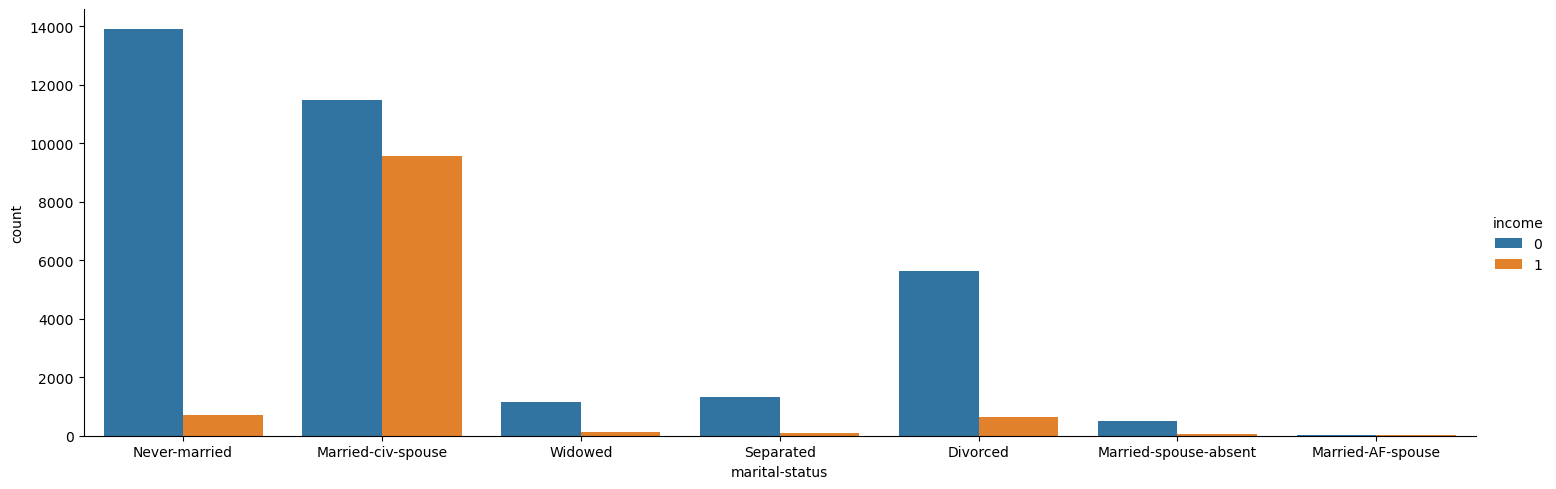

In [29]:
marriage_data = newdf[['marital-status', 'income']]
marriage = sns.catplot(x='marital-status', hue='income', data=marriage_data, kind='count', aspect=3)

In this graph, we can see that most people with income as '>50K' are getting intact marrriages.

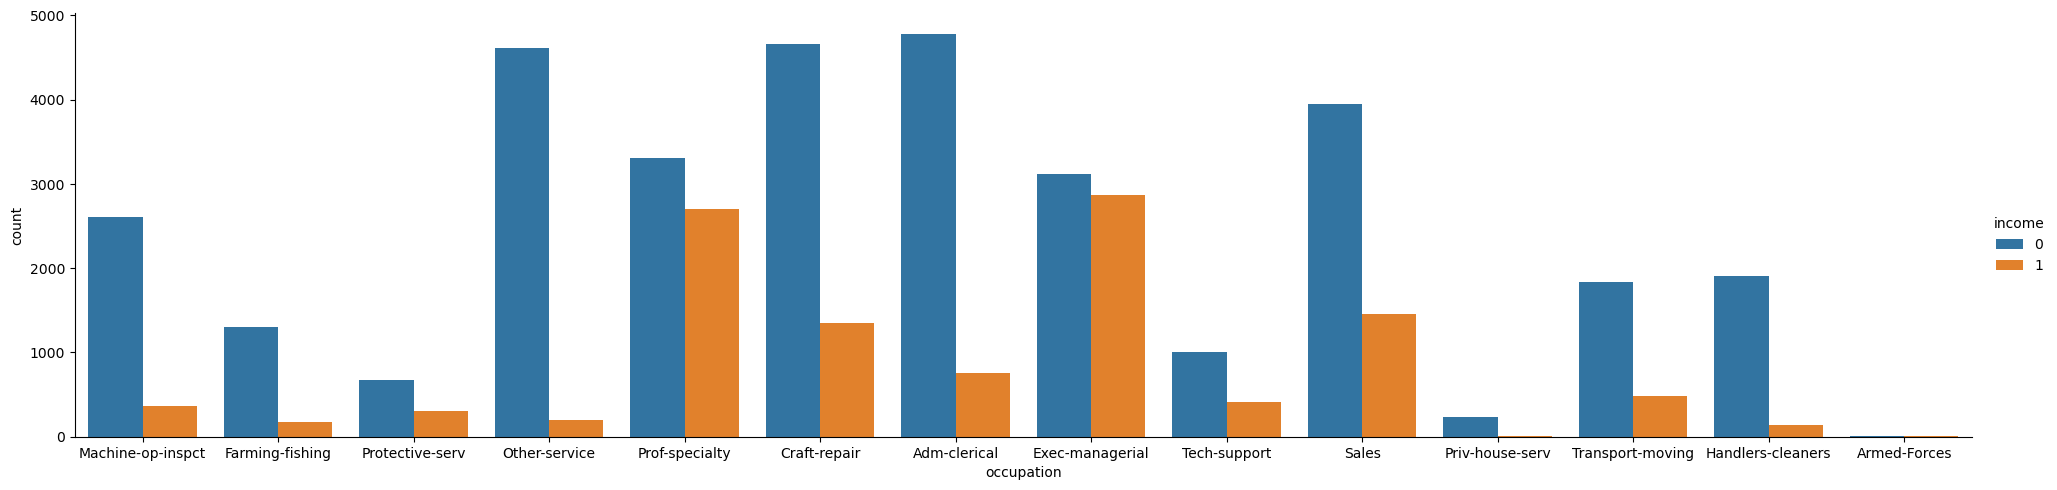

In [30]:
occupation_data = newdf[['occupation', 'income']]
occupation = sns.catplot(x='occupation', hue='income', data=occupation_data, kind='count', aspect=4)

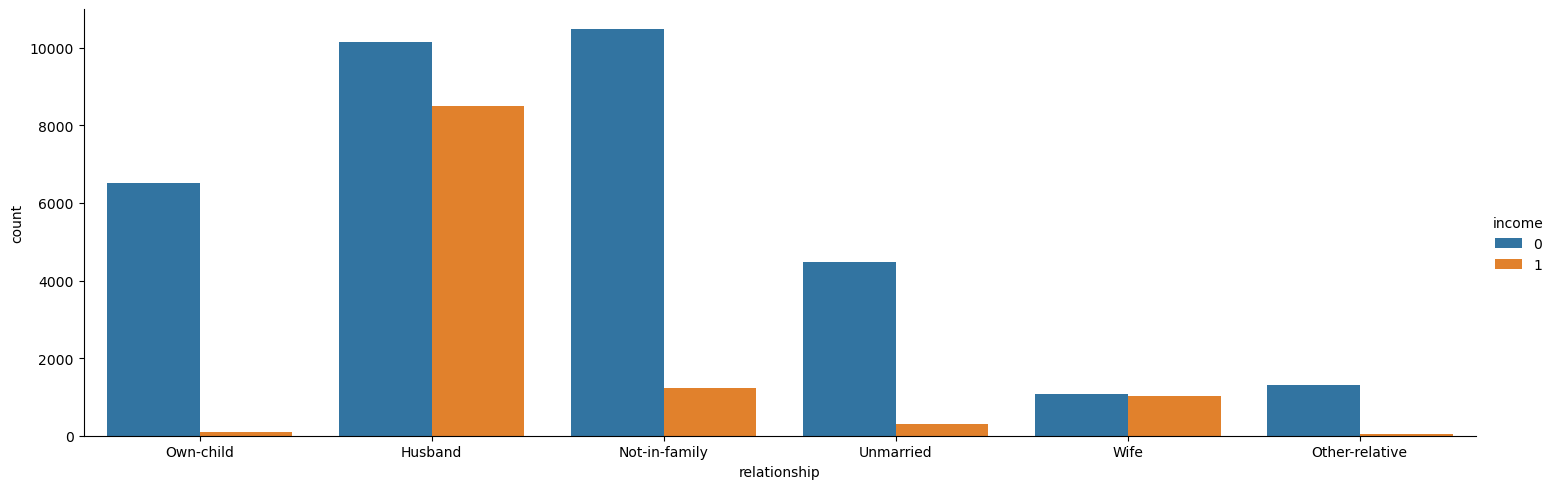

In [31]:
relationship_data = newdf[['relationship', 'income']]
relationship = sns.catplot(x='relationship', hue='income', data=relationship_data, kind='count', aspect=3)

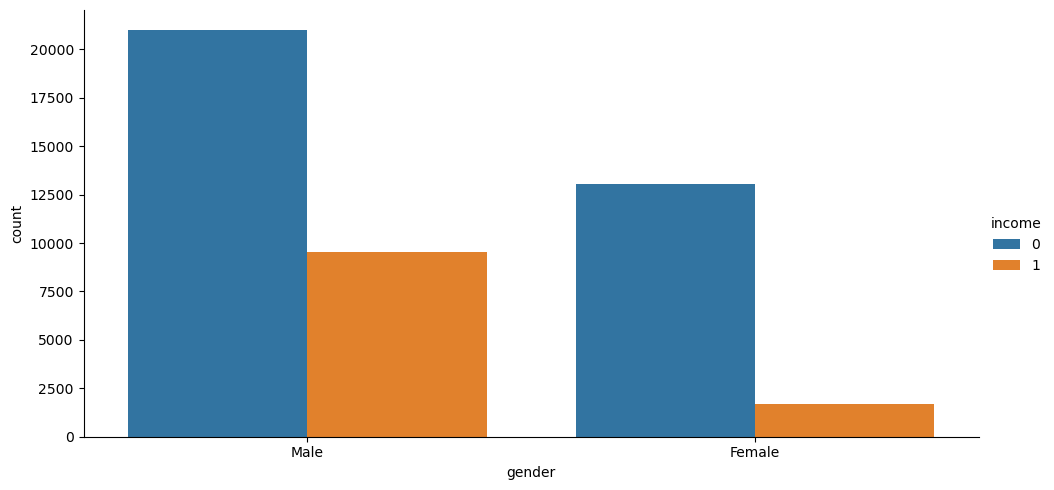

In [32]:
gender_data = newdf[['gender', 'income']]
gender = sns.catplot(x='gender', hue='income', data=gender_data, kind='count', aspect=2)

According to the last two graphs, husband are more easily to have income as '>50K'.

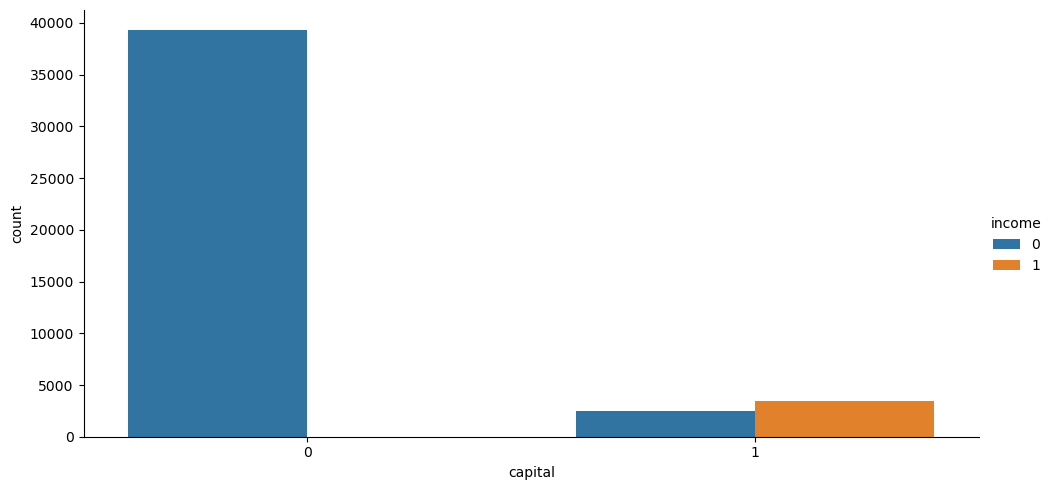

In [33]:
capital_data = newdf[['capital-gain', 'capital-loss', 'income']]
capital_data['capital'] = 1
capital_data[(capital_data['capital-gain']==0) & (capital_data['capital-loss']==0)] = 0
capital = sns.catplot(x='capital', hue='income', data=capital_data, kind='count', aspect=2)

Capital=0 means people have no capital income. So this graph shows all people with income as '>50K' have capital gain or loss. 

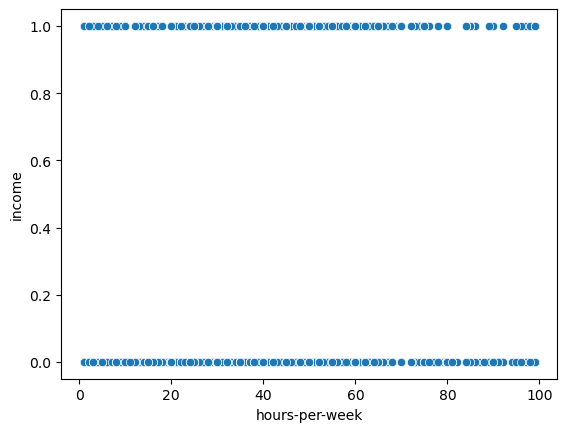

In [34]:
time_data = newdf[['hours-per-week', 'income']]
time = sns.scatterplot(x='hours-per-week', y='income',data=time_data)

So working hours have no really strong relationship with income.

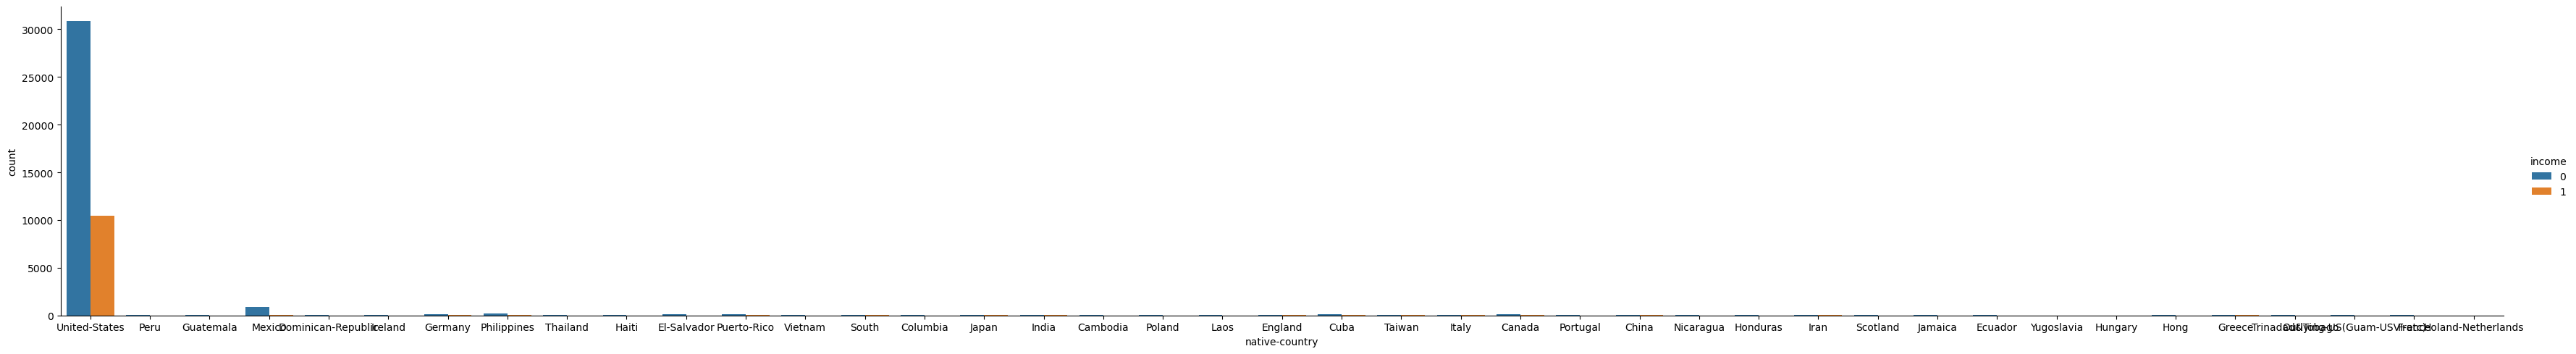

In [35]:
location_data = newdf[['native-country', 'income']]
location = sns.catplot(x='native-country', hue='income', data=location_data, kind='count', aspect=7)

In this reasearch, most people are from United-States.